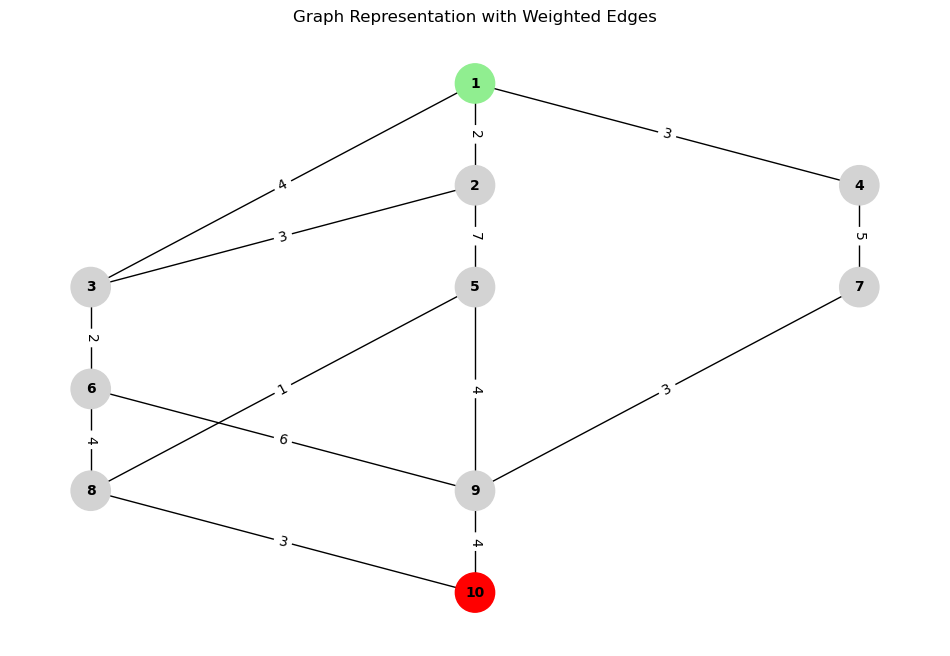

Topology matrix T: {1: {2: 2, 3: 4, 4: 3}, 2: {1: 2, 5: 7, 3: 3}, 3: {1: 4, 2: 3, 6: 2}, 4: {1: 3, 7: 5}, 5: {2: 7, 8: 1, 9: 4}, 6: {3: 2, 8: 4, 9: 6}, 7: {4: 5, 9: 3}, 8: {5: 1, 6: 4, 10: 3}, 9: {5: 4, 6: 6, 7: 3, 10: 4}, 10: {8: 3, 9: 4}}
Shortest path from 1 to 10: [1, 2, 5, 8, 10]
Length of the shortest path: 13
Optimal path from 1 to [10] using Q-learning: [1, 2, 5, 8, 10]
Length of the optimal path: 13


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

start = 1
end = 10
max_length = 10

# Initialize a graph
G = nx.Graph()

# Add nodes
nodes = range(1, 11)
G.add_nodes_from(nodes)

# Define edges with weights
edges = [
    (1, 2, 2), (1, 3, 4), (1, 4, 3), (2, 5, 7), (2, 3, 3), 
    (3, 6, 2), (4, 7, 5), (5, 8, 1), (5, 9, 4), (6, 8, 4), 
    (6, 9, 6), (7, 9, 3), (8, 10, 3), (9, 10, 4)
]

# Add edges with weights to the graph
G.add_weighted_edges_from(edges)

# Define node colors
node_colors = ['lightgreen' if node == start else 'red' if node == end else 'lightgray' for node in nodes]

# Define position layout
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, pos, node_color=node_colors, with_labels=True, node_size=800, font_size=10, font_color='black', font_weight='bold', edge_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}, font_color='black')

# Display the graph
plt.title("Graph Representation with Weighted Edges")
plt.axis('off')
plt.show()

# Create the topology matrix T from edges
T = {}
for u, v, d in G.edges(data=True):
    if u not in T:
        T[u] = {}
    if v not in T:
        T[v] = {}
    T[u][v] = d['weight']
    T[v][u] = d['weight']

print("Topology matrix T:", T)

# Shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=start, target=end, weight='weight')
shortest_path_length = nx.shortest_path_length(G, source=start, target=end, weight='weight')

print(f"Shortest path from {start} to {end}:", shortest_path)
print("Length of the shortest path:", shortest_path_length)

def Q_routing(T, Q, alpha, epsilon, num_episodes, start, end):
    for e in range(num_episodes):
        state_cur = start
        visited = set()
        length = 0
        goal = False

        while not goal:
            mov_valid = list(Q[state_cur].keys())

            if len(mov_valid) <= 1:
                state_nxt = mov_valid[0]
            else:
                act_best = random.choice(get_key_of_min_value(Q[state_cur]))
                if random.random() < epsilon:
                    mov_valid.remove(act_best)
                    state_nxt = random.choice(mov_valid)
                else:
                    state_nxt = act_best

            Q = Q_update(T, Q, state_cur, state_nxt, alpha, visited)

            if state_nxt in end:
                goal = True
            state_cur = state_nxt
            if state_cur in visited or length >= max_length:
                break
            visited.add(state_cur)
            length += 1

    return Q

def Q_update(T, Q, state_cur, state_nxt, alpha, visited):
    t_cur = T[state_cur][state_nxt]
    q_cur = Q[state_cur][state_nxt]
    loop = 0
    if state_nxt in visited:
        loop = 10
    if state_nxt in Q:
        q_new = q_cur + alpha * (t_cur + min(Q[state_nxt].values()) + loop - q_cur)
        Q[state_cur][state_nxt] = q_new
    return Q

def get_key_of_min_value(d):
    min_value = min(d.values())
    return [k for k, v in d.items() if v == min_value]

def extract_best_path(Q, start, end):
    path = [start]
    current = start
    while current not in end:
        next_state = min(Q[current], key=Q[current].get)
        path.append(next_state)
        current = next_state
    return path

# Example usage:
Q = {state: {next_state: 0 for next_state in T[state]} for state in T}

alpha = 0.1
epsilon = 0.1
num_episodes = 10000
start = 1
end = [end]

Q = Q_routing(T, Q, alpha, epsilon, num_episodes, start, end)
optimal_path = extract_best_path(Q, start, end)
path_length = sum(T[optimal_path[i]][optimal_path[i + 1]] for i in range(len(optimal_path) - 1))

print(f"Optimal path from {start} to {end} using Q-learning:", optimal_path)
print("Length of the optimal path:", path_length)
